PWC-Net-large model evaluation (on FlyingChairs validation split)
======================================================

In this notebook we:
- Evaluate the PWC-Net-large model trained on a mix of the `FlyingChairs` and `FlyingThings3DHalfRes` datasets using the multisteps S<sub>long</sub> schedule
- Run the evaluation on the **validation split** of the `FlyingChairs` dataset, yielding an average EPE of 1.44 with pwcnet.ckpt-595000
- Perform basic error analysis

Below, look for `TODO` references and customize this notebook based on your own machine setup.

## Reference

[2018a]<a name="2018a"></a> Sun et al. 2018. PWC-Net: CNNs for Optical Flow Using Pyramid, Warping, and Cost Volume. [[arXiv]](https://arxiv.org/abs/1709.02371) [[web]](http://research.nvidia.com/publication/2018-02_PWC-Net%3A-CNNs-for) [[PyTorch (Official)]](https://github.com/NVlabs/PWC-Net/tree/master/PyTorch) [[Caffe (Official)]](https://github.com/NVlabs/PWC-Net/tree/master/Caffe)

In [1]:
"""
pwcnet_eval.ipynb

PWC-Net model evaluation.

Written by Phil Ferriere

Licensed under the MIT License (see LICENSE for details)
"""
from __future__ import absolute_import, division, print_function
import sys
from copy import deepcopy
import pandas as pd
import seaborn as sns

from dataset_base import _DEFAULT_DS_VAL_OPTIONS
from dataset_flyingchairs import FlyingChairsDataset
from model_pwcnet import ModelPWCNet, _DEFAULT_PWCNET_VAL_OPTIONS
from visualize import display_img_pairs_w_flows

%matplotlib inline

## TODO: Set this first!

In [2]:
# TODO: You MUST set dataset_root to the correct path on your machine!
if sys.platform.startswith("win"):
    _DATASET_ROOT = 'E:/datasets/'
else:
    _DATASET_ROOT = '/media/EDrive/datasets/'
_FLYINGCHAIRS_ROOT = _DATASET_ROOT + 'FlyingChairs_release'
    
# TODO: Set device on which to perform the evaluation
gpu_devices = ['/device:GPU:0'] # We're doing the evaluation on a single GPU
controller = '/device:GPU:0'

# More options...
mode = 'val'            # We're doing the evaluation on the validation split of the dataset
num_samples = 10        # Number of samples for error analysis
ckpt_path = './models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000' # Model to eval

## Load the dataset

In [3]:
# Load the dataset in evaluation mode, starting with the default evaluation options
ds_opts = deepcopy(_DEFAULT_DS_VAL_OPTIONS)
ds = FlyingChairsDataset(mode=mode, ds_root=_FLYINGCHAIRS_ROOT, options=ds_opts)

In [4]:
# Display dataset configuration
ds.print_config()


Dataset Configuration:
  verbose              False
  in_memory            False
  crop_preproc         None
  scale_preproc        None
  input_channels       3
  type                 final
  random_seed          1969
  val_split            0.03
  aug_type             None
  mode                 val
  val size             640


## Configure the evaluation process

In [5]:
# Configure the model for evaluation, starting with the default evaluation options
nn_opts = deepcopy(_DEFAULT_PWCNET_VAL_OPTIONS)
nn_opts['verbose'] = True
nn_opts['ckpt_path'] = ckpt_path
nn_opts['batch_size'] = 1               # Setting this to 1 leads to more accurate evaluations of the processing time 
nn_opts['use_tf_data'] = False          # Don't use tf.data reader for this simple task
nn_opts['gpu_devices'] = gpu_devices
nn_opts['controller'] = controller      # Evaluate on CPU or GPU?

# We're evaluating the PWC-Net-large model in quarter-resolution mode
# That is, with a 6 level pyramid, and uspampling of level 2 by 4 in each dimension as the final flow prediction
nn_opts['use_dense_cx'] = True
nn_opts['use_res_cx'] = True
nn_opts['pyr_lvls'] = 6
nn_opts['flow_pred_lvl'] = 2

In [6]:
# Instantiate the model in evaluation mode and display the model configuration
nn = ModelPWCNet(mode=mode, options=nn_opts, dataset=ds)
nn.print_config()

Building model...
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
... model built.
Loading model checkpoint ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  adapt_info             None
  sparse_gt_flow         False
  gpu_devices            ['/device:GPU:0']
  controller             /device:GPU:0
  batch_size             1
  use_tf_data            False
  use_mixed_precision    False
  pyr_lvls               6
  flow_pred_lvl          2
  search_range           4
  use_

## Evaluate the model

In [7]:
# Evaluate the performance of the model on the dataset
# Save the predictions to disk for error analysis
# Also, get a panda dataframe with info about each sample for further error analysis
avg_metric, avg_duration, df = nn.eval(metric_name='EPE', save_preds=True)

Measuring EPE and saving preds: 100%|#############################| 640/640 [01:17<00:00,  8.22it/s]


In [8]:
print(f'Average EPE={avg_metric:.2f}, mean inference time={avg_duration*1000.:.2f}ms')

Average EPE=1.44, mean inference time=51.43ms


## Error analysis

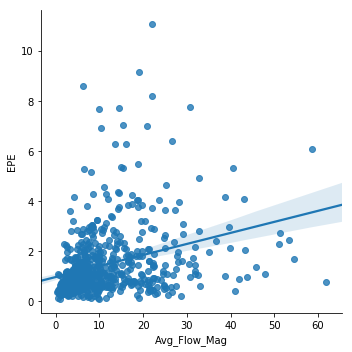

In [9]:
# Is there a correlation between average flow magnitude and EPE?
sns.lmplot(x='Avg_Flow_Mag', y='EPE', data=df, fit_reg=True)

In [10]:
# Which are the 10 worst performers by EPE?
df = df.sort_values(by='EPE')
df_worst = df.tail(num_samples).iloc[::-1]
df_worst

ID        EPE  Duration  Avg_Flow_Mag  Max_Flow_Mag
373  pair_08968  11.076161  0.043882     22.136482    149.304367
374  pair_06674   9.157344  0.042885     18.989414     81.363411
63   pair_01154   8.591320  0.043882      6.186900     89.141205
505  pair_03184   8.179824  0.042885     22.147058    125.938072
455  pair_06700   7.742949  0.045877     30.789297    124.325905
31   pair_14518   7.690435  0.043882     14.384866     55.271973
53   pair_00594   7.686495  0.044880      9.930667     92.277039
113  pair_02400   7.048891  0.045877     15.307540    129.531158
26   pair_05228   6.984041  0.043884     20.873890    145.369247
353  pair_06411   6.904001  0.044878     10.354102    126.063034

In [11]:
mean_avg_flow_mag = df['Avg_Flow_Mag'].mean()
mean_avg_flow_mag

10.962106155324728

In [12]:
# Which are the 10 best performers with an average flow magnitude?
mean_avg_flow_mag = df['Avg_Flow_Mag'].mean()
df_best = df[df['Avg_Flow_Mag'] >= mean_avg_flow_mag].sort_values(by='EPE').head(int(num_samples))
df_best

ID       EPE  Duration  Avg_Flow_Mag  Max_Flow_Mag
592  pair_08408  0.126257  0.043883     11.634827     21.591932
473  pair_01962  0.128561  0.041888     19.141796     36.698746
347  pair_03277  0.219496  0.042885     28.743074     35.256226
0    pair_02420  0.240544  4.535882     25.680052     46.915352
119  pair_00132  0.240952  0.043882     18.524956     35.912006
468  pair_00296  0.275891  0.044880     22.670059     43.639633
411  pair_22867  0.299930  0.044880     12.411869     22.958912
134  pair_09201  0.321169  0.044880     23.275902     30.134291
11   pair_08172  0.345684  0.043883     21.148079     77.879196
128  pair_10306  0.357414  0.044879     26.654434     46.148090

# Visual assessment

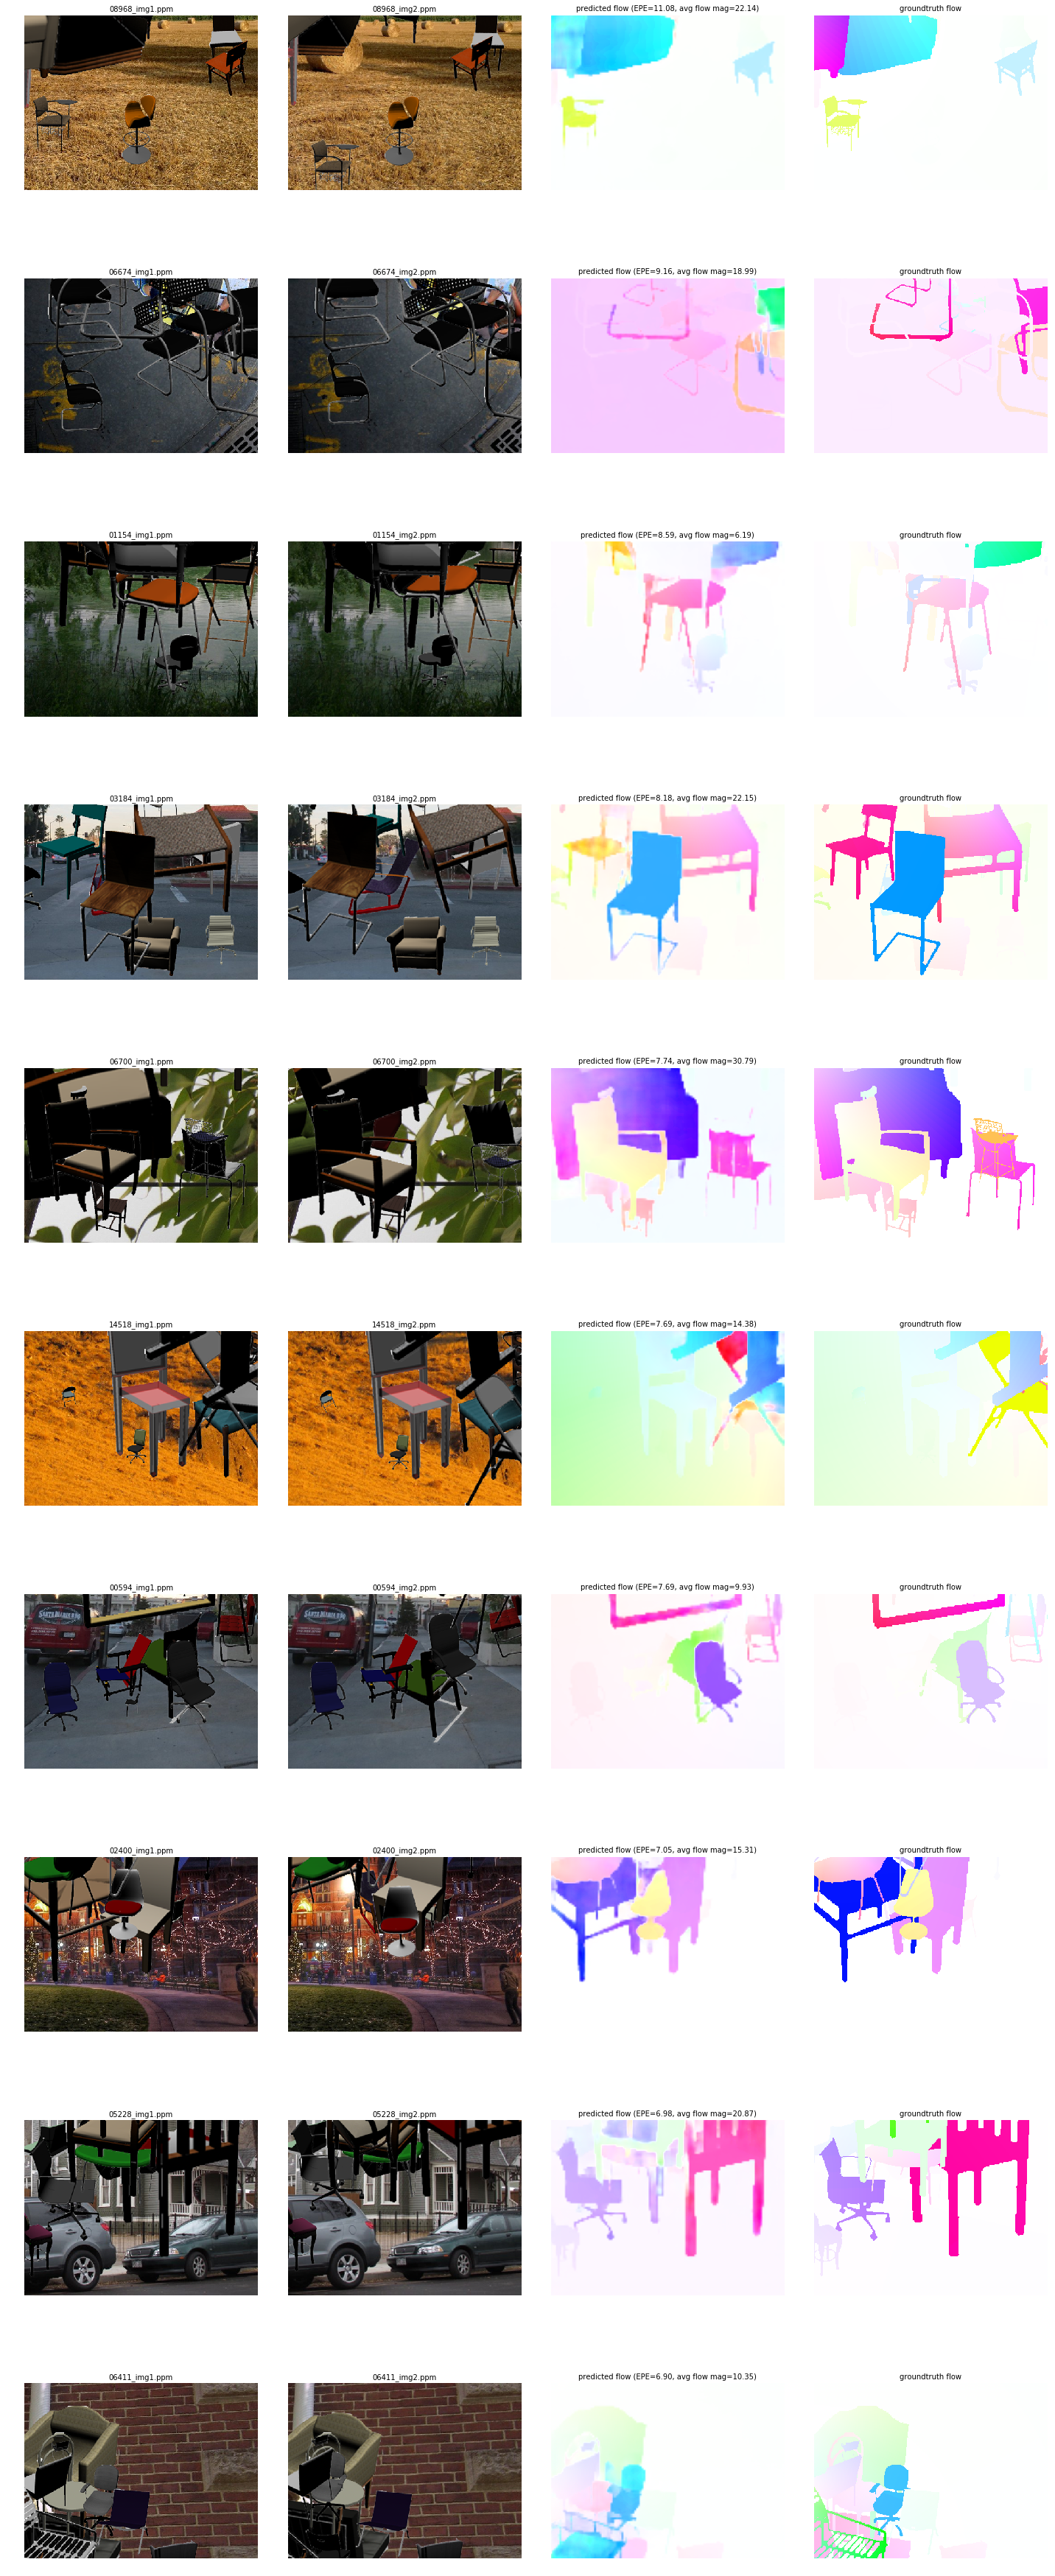

In [13]:
# How do the 10 worst performers look like?
images, labels, pred_labels, ids = ds.get_samples_by_flow_ID(list(df_worst['ID']), split='val_with_preds')
info_text = [f"(EPE={stat[0]:.2f}, avg flow mag={stat[1]:.2f})" for stat in zip(df_worst['EPE'], df_worst['Avg_Flow_Mag'])]
display_img_pairs_w_flows(images, pred_labels, labels, ids, info_text)

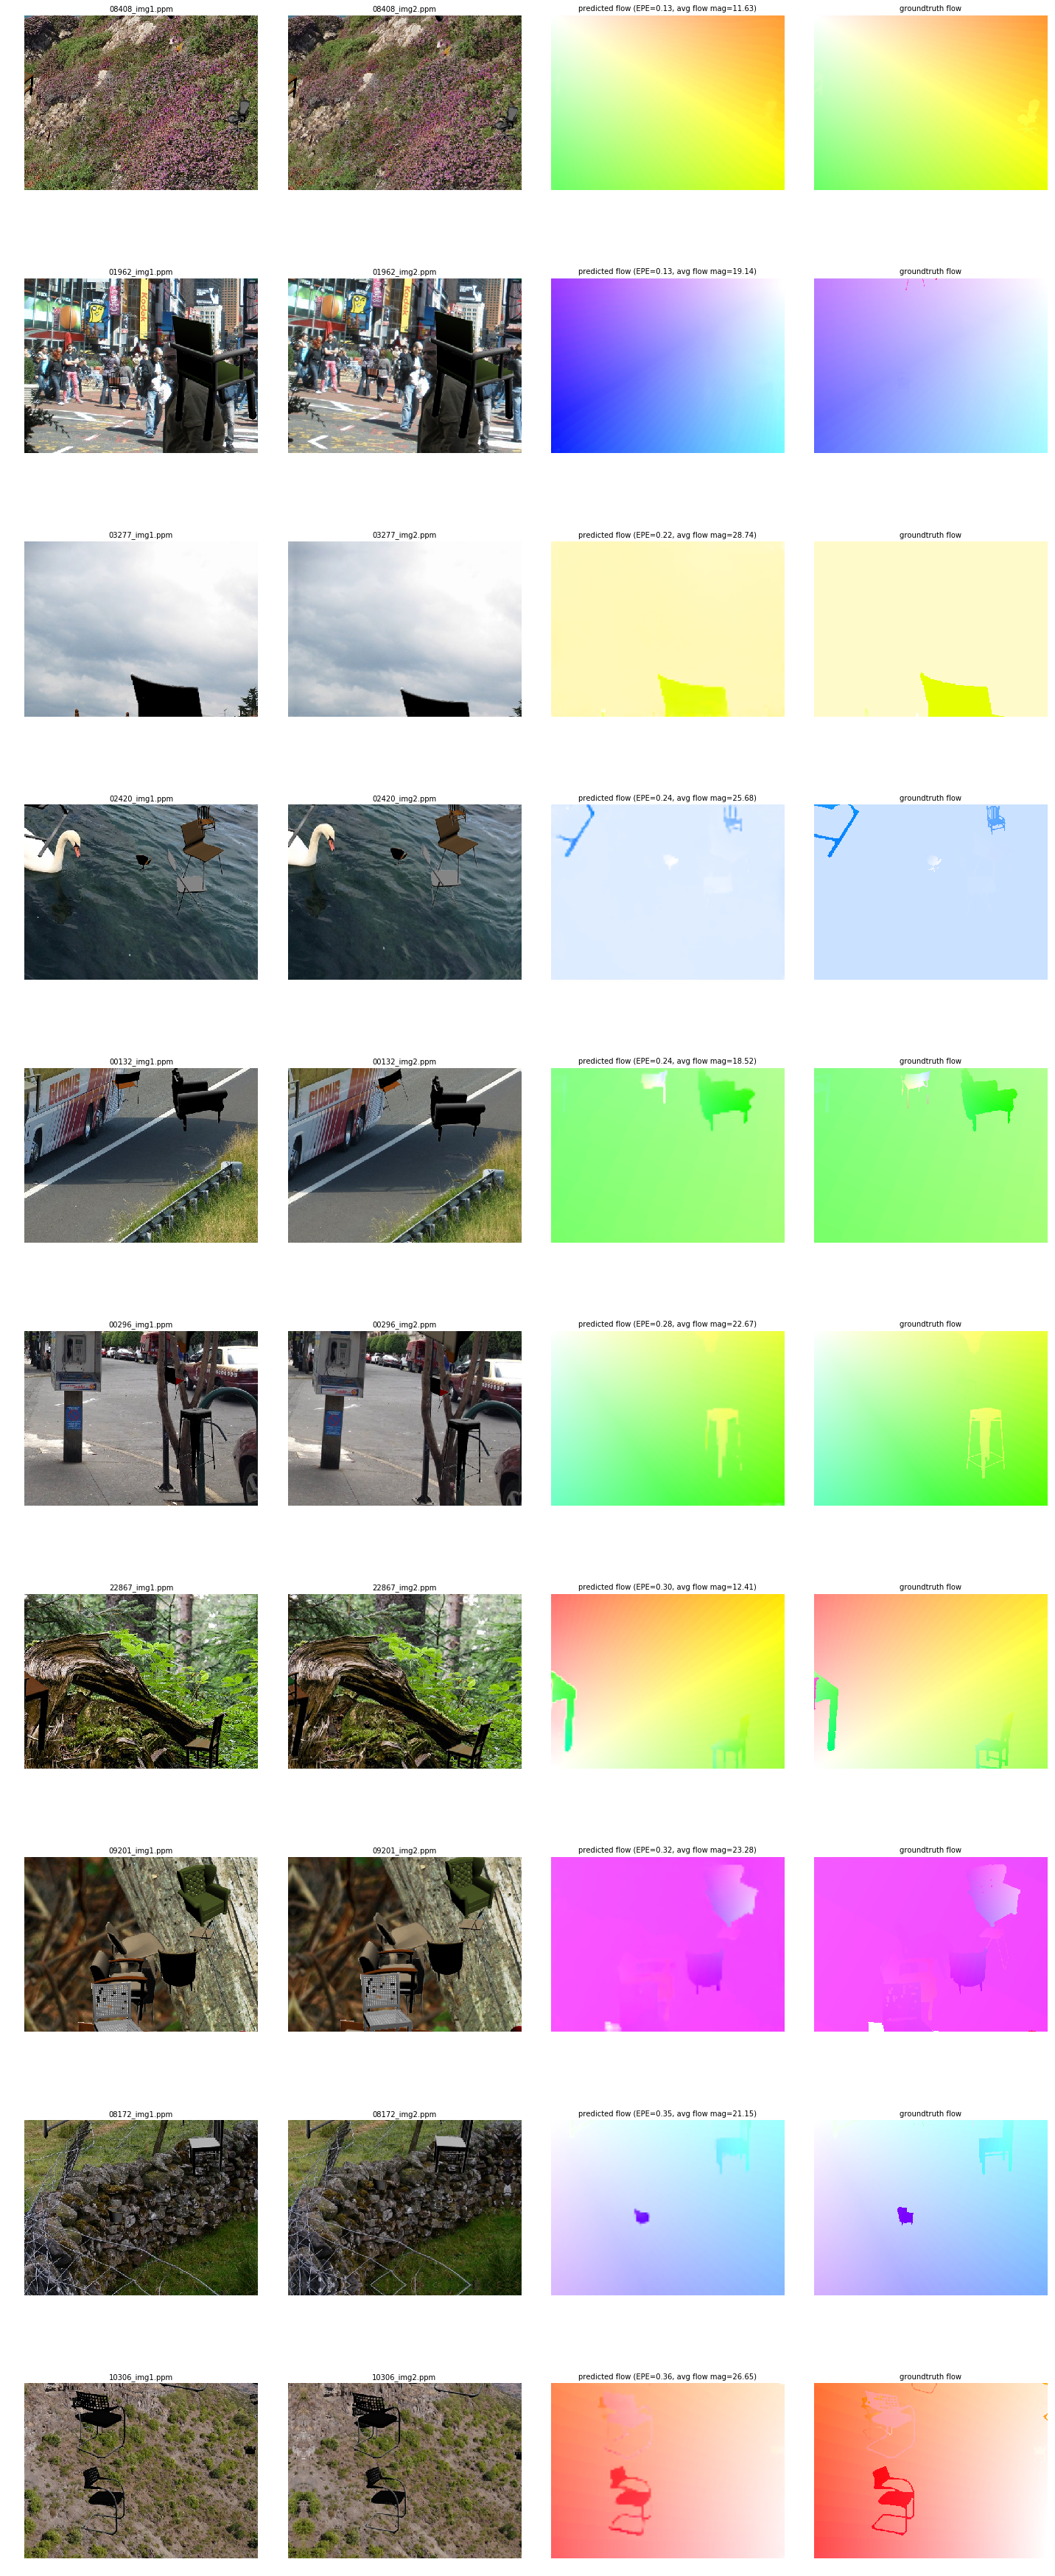

In [14]:
# How do the 10 best performers (with average flow mag) look like?
images, labels, pred_labels, ids = ds.get_samples_by_flow_ID(list(df_best['ID']), split='val_with_preds')
info_text = [f"(EPE={stat[0]:.2f}, avg flow mag={stat[1]:.2f})" for stat in zip(df_best['EPE'], df_best['Avg_Flow_Mag'])]
display_img_pairs_w_flows(images, pred_labels, labels, ids, info_text)